# Trying to measure the causal impact of mentioning an unusual term on a TV show 

In [20]:
import os
import numpy as np
import pandas as pd
from causalimpact import CausalImpact
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
sns.set(style="ticks", context='talk')

warnings.filterwarnings("ignore")
%matplotlib inline

# Gathering the data

In [2]:
# !pip install pytrends

In [6]:
from pytrends.request import TrendReq

pytrends = TrendReq(hl="pt-BR", tz=45, timeout=(10, 25), retries=2, backoff_factor=0.1)

In [7]:
kw_list = ["sororidade", "futebol", "carro", "temperatura", "restaurante"]
pytrends.build_payload(kw_list, cat=0, timeframe='2020-02-06T08 2020-02-13T07')

In [8]:
df = pytrends.interest_over_time()

In [9]:
df.head()

,sororidade,futebol,carro,temperatura,restaurante,isPartial
date,,,,,,
2020-02-06 08:00:00,0,1,2,9,4,False
2020-02-06 09:00:00,0,2,4,11,6,False
2020-02-06 10:00:00,0,2,7,13,8,False
2020-02-06 11:00:00,0,2,8,17,10,False
2020-02-06 12:00:00,0,2,10,22,13,False


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 168 entries, 2020-02-06 08:00:00 to 2020-02-13 07:00:00
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   sororidade   168 non-null    int64
 1   futebol      168 non-null    int64
 2   carro        168 non-null    int64
 3   temperatura  168 non-null    int64
 4   restaurante  168 non-null    int64
 5   isPartial    168 non-null    bool 
dtypes: bool(1), int64(5)
memory usage: 8.0 KB


In [16]:
# !pip install tabulate

In [15]:
print(df.head().to_markdown())

| date                |   sororidade |   futebol |   carro |   temperatura |   restaurante | isPartial   |
|:--------------------|-------------:|----------:|--------:|--------------:|--------------:|:------------|
| 2020-02-06 08:00:00 |            0 |         1 |       2 |             9 |             4 | False       |
| 2020-02-06 09:00:00 |            0 |         2 |       4 |            11 |             6 | False       |
| 2020-02-06 10:00:00 |            0 |         2 |       7 |            13 |             8 | False       |
| 2020-02-06 11:00:00 |            0 |         2 |       8 |            17 |            10 | False       |
| 2020-02-06 12:00:00 |            0 |         2 |      10 |            22 |            13 | False       |


# Bonus
You can also download from the website and do this process manually

In [9]:
df = (
    pd.read_csv("data/sororidade.csv", skiprows=1)
    .merge(pd.read_csv("data/temperatura.csv", skiprows=1), on="Tempo")
    .merge(pd.read_csv("data/carro.csv", skiprows=1), on="Tempo")
    .merge(pd.read_csv("data/restaurante.csv", skiprows=1), on="Tempo")
    .merge(pd.read_csv("data/futebol.csv", skiprows=1), on="Tempo")
)

In [14]:
df["sororidade: (Brasil)"] = (
    df["sororidade: (Brasil)"].astype(str).str.replace("<", "", regex=False).astype(int)
)

In [10]:
df.shape

(168, 6)

# Organizing the data

In [17]:
df = df.drop(columns=["isPartial"])

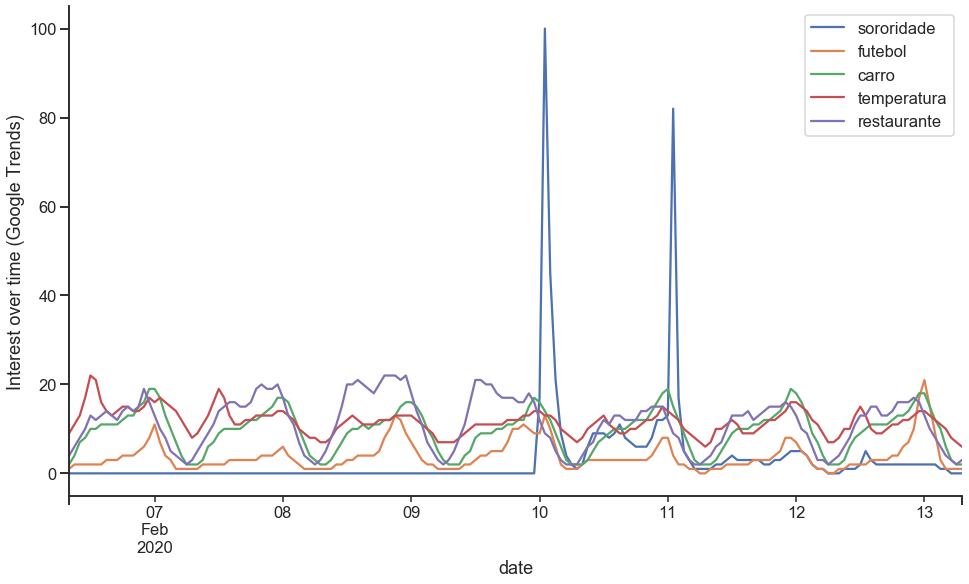

In [15]:
df.plot(figsize=[16,9])
sns.despine()
plt.ylabel("Interest over time (Google Trends)")
plt.xticks(rotation=45);

In [18]:
# changing the zeroes to 0.1 so the model can converge
df["sororidade"] = df["sororidade"].apply(lambda x: 0.1 if x==0 else x)

In [19]:
df.head()

,sororidade,futebol,carro,temperatura,restaurante
date,,,,,
2020-02-06 08:00:00,0.1,1,2,9,4
2020-02-06 09:00:00,0.1,2,4,11,6
2020-02-06 10:00:00,0.1,2,7,13,8
2020-02-06 11:00:00,0.1,2,8,17,10
2020-02-06 12:00:00,0.1,2,10,22,13


In [39]:
pre_period = [
    pd.to_datetime(np.min(df.index.values)),
    pd.to_datetime(np.datetime64("2020-02-09T22:00:00.000000000")),
]
post_period = [
    pd.to_datetime(np.datetime64("2020-02-09T23:00:00.000000000")),
    pd.to_datetime(np.max(df.index.values)),
]

ci = CausalImpact(df, pre_period, post_period)
print(ci.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    6.84               553.7
Prediction (s.d.)         0.1 (0.0)          8.1 (0.0)
95% CI                    [0.1, 0.1]         [8.1, 8.1]

Absolute effect (s.d.)    6.74 (0.0)         545.6 (0.0)
95% CI                    [6.74, 6.74]       [545.6, 545.6]

Relative effect (s.d.)    6735.8% (0.0%)     6735.8% (0.0%)
95% CI                    [6735.8%, 6735.8%] [6735.8%, 6735.8%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


In [40]:
print(ci.summary(output='report'))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 6.84. By contrast, in the absence of an
intervention, we would have expected an average response of 0.1.
The 95% interval of this counterfactual prediction is [0.1, 0.1].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 6.74 with a 95% interval of
[6.74, 6.74]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 553.7.
By contrast, had the intervention not taken place, we would have expected
a sum of 8.1. The 95% interval of this prediction is [8.1, 8.1].


The above results are given in terms of absolute numbers. In relative
terms, the response variable showed an increas

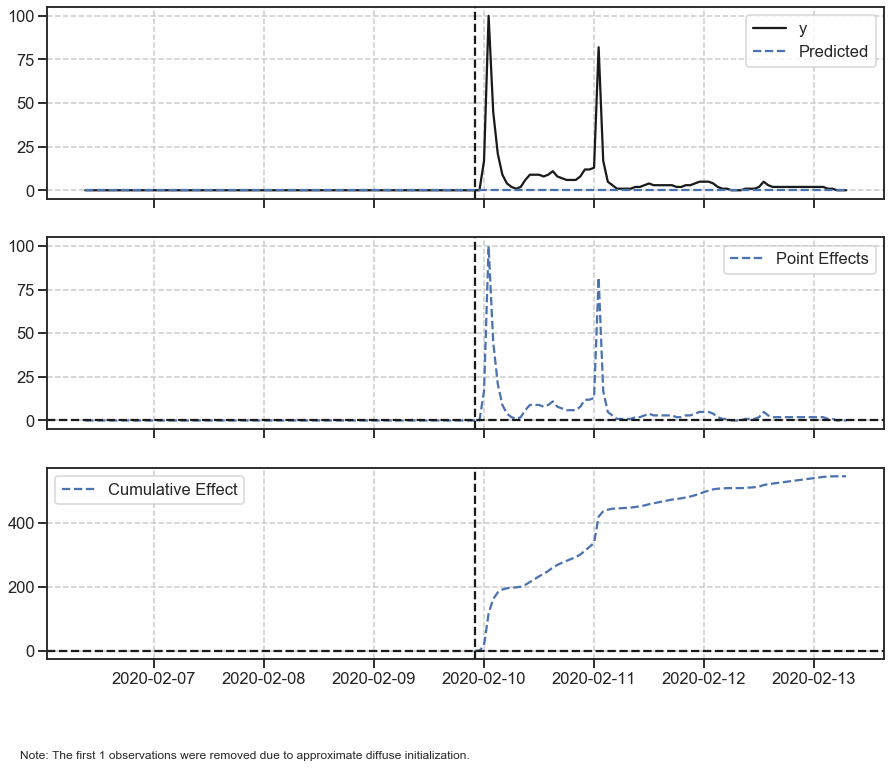

In [41]:
ci.plot()

In [42]:
ci.inferences.head()

,post_cum_y,preds,post_preds,post_preds_lower,post_preds_upper,preds_lower,preds_upper,post_cum_pred,post_cum_pred_lower,post_cum_pred_upper,point_effects,point_effects_lower,point_effects_upper,post_cum_effects,post_cum_effects_lower,post_cum_effects_upper
2020-02-06 08:00:00,NaN,0.1,NaN,NaN,NaN,0.1,0.1,NaN,NaN,NaN,1.804112e-16,-3.534256e-13,3.537864e-13,NaN,NaN,NaN
2020-02-06 09:00:00,NaN,0.1,NaN,NaN,NaN,0.1,0.1,NaN,NaN,NaN,0.000000e+00,0.000000e+00,0.000000e+00,NaN,NaN,NaN
2020-02-06 10:00:00,NaN,0.1,NaN,NaN,NaN,0.1,0.1,NaN,NaN,NaN,0.000000e+00,0.000000e+00,0.000000e+00,NaN,NaN,NaN
2020-02-06 11:00:00,NaN,0.1,NaN,NaN,NaN,0.1,0.1,NaN,NaN,NaN,0.000000e+00,0.000000e+00,0.000000e+00,NaN,NaN,NaN
2020-02-06 12:00:00,NaN,0.1,NaN,NaN,NaN,0.1,0.1,NaN,NaN,NaN,0.000000e+00,0.000000e+00,0.000000e+00,NaN,NaN,NaN
